# Prepare to train

**Use pretrained from hugging face**

In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import time

**Pytorch MRI Dataset**

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
import os
import torch
import cv2 
from PIL import Image

class MRIDataset(Dataset):
    def __init__(self, root, transform=None):
        super(MRIDataset, self).__init__()
        self.root = root
        if transform is None:
            self.transform = transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                 transforms.Resize((224, 224))])
        else:
            self.transform = transform
        # Load the data and labels
        self.data, self.labels = self._load_data()

    def _load_data(self):
        # Load the MRI data and labels from the specified directory
        data = []
        labels = []

        #label is subfoder name
        for label in os.listdir(self.root):
            label_dir = os.path.join(self.root, label)
            if os.path.isdir(label_dir):
                for file in os.listdir(label_dir):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        img_path = os.path.join(label_dir, file)
                        img = nib.load(img_path).get_fdata()
                        img = torch.tensor(img).unsqueeze(3).numpy()
                        # Convert the image to a dynamic image
                        img = self.get_dynamic_image(img)
                        data.append(img)
                        labels.append(label)
                        # Show progess every 100 images
                        if len(data) % 100 == 0:
                            print(f"Loaded {len(data)} images")

        # one-hot encode the labels
        unique_labels = list(set(labels))
        label_to_index = {label: index for index, label in enumerate(unique_labels)}
        labels = [label_to_index[label] for label in labels]

        return data, labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Convert the image to a PIL Image for transformation
        img = Image.fromarray(img.astype(np.uint8)).convert('RGB')

        # Apply the transform if specified
        if self.transform:
            img = self.transform(img)

        return img, label
    
    def get_dynamic_image(self, frames, normalized=True):
        """ Adapted from https://github.com/tcvrick/Python-Dynamic-Images-for-Action-Recognition"""
        """ Takes a list of frames and returns either a raw or normalized dynamic image."""
        
        def _get_channel_frames(iter_frames, num_channels):
            """ Takes a list of frames and returns a list of frame lists split by channel. """
            frames = [[] for channel in range(num_channels)]

            for frame in iter_frames:
                for channel_frames, channel in zip(frames, cv2.split(frame)):
                    channel_frames.append(channel.reshape((*channel.shape[0:2], 1)))
            for i in range(len(frames)):
                frames[i] = np.array(frames[i])
            return frames


        def _compute_dynamic_image(frames):
            """ Adapted from https://github.com/hbilen/dynamic-image-nets """
            frames = np.transpose(frames, (2, 1, 0, 3)) # updown
            num_frames, h, w, depth = frames.shape

            # Compute the coefficients for the frames.
            coefficients = np.zeros(num_frames)
            for n in range(num_frames):
                cumulative_indices = np.array(range(n, num_frames)) + 1
                coefficients[n] = np.sum(((2*cumulative_indices) - num_frames) / cumulative_indices)

            # Multiply by the frames by the coefficients and sum the result.
            x1 = np.expand_dims(frames, axis=0)
            x2 = np.reshape(coefficients, (num_frames, 1, 1, 1))
            result = x1 * x2
            return np.sum(result[0], axis=0).squeeze()

        num_channels = frames[0].shape[2]
        channel_frames = _get_channel_frames(frames, num_channels)
        channel_dynamic_images = [_compute_dynamic_image(channel) for channel in channel_frames]

        dynamic_image = cv2.merge(tuple(channel_dynamic_images))
        #convert to grayscale

        if normalized:
            dynamic_image = cv2.normalize(dynamic_image, None, 0, 255, norm_type=cv2.NORM_MINMAX)
            dynamic_image = dynamic_image.astype('uint8')

        return dynamic_image

**Train, test function**

In [4]:
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    running_loss = 0.0
    all_labels = []
    all_preds = []
    all_time = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            time_taken = end_time - start_time
            all_time.append(time_taken)

            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_time = sum(all_time) / len(all_time)
    return running_loss / len(test_loader), accuracy, f1, avg_time


In [5]:
#device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Define hyperparameters**

In [6]:
epochs = 100
batch_size = 32
lr = 0.001
num_classes = 3
patience = 10

In [ ]:
from torch.utils.data import DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split

train_dataset = MRIDataset(root='/train')
valid_dataset = MRIDataset(root='/valid')
test_dataset = MRIDataset(root='/test')

# 0: bad, 1: good, 2: defect
print(f'Train dataset size: {len(train_dataset)}')
print(f'Valid dataset size: {len(valid_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Train dataset class distribution: {Counter(train_dataset.labels)}') # Access labels using original dataset and indices
print(f'Valid dataset class distribution: {Counter(valid_dataset.labels)}') # Access labels using original dataset and indices
print(f'Test dataset class distribution: {Counter(test_dataset.labels)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Loaded 500 images
Loaded 600 images
Loaded 700 images
Loaded 800 images
Loaded 900 images
Loaded 1000 images
Loaded 1100 images
Loaded 1200 images
Loaded 1300 images
Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Train dataset size: 1376
Valid dataset size: 459
Test dataset size: 459
Train dataset class distribution: Counter({1: 688, 0: 420, 2: 268})
Valid dataset class distribution: Counter({1: 210, 0: 147, 2: 102})
Test dataset class distribution: Counter({1: 215, 0: 138, 2: 106})


In [8]:
print("Image Shape", train_dataset[0][0].shape)

Image Shape torch.Size([3, 224, 224])


# MobileNetV1

**MobileNetV1 pretrained from transformers HuggingFace**

In [9]:
from transformers import MobileNetV1ForImageClassification

mobilenetv1 = MobileNetV1ForImageClassification.from_pretrained('google/mobilenet_v1_1.0_224')

mobilenetv1.classifier = nn.Linear(mobilenetv1.classifier.in_features, out_features=num_classes, bias=True)
mobilenetv1.dropout = nn.Dropout(p=0.5)

mobilenetv1.to(device)

print(mobilenetv1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv1.parameters(), lr=lr)

MobileNetV1ForImageClassification(
  (mobilenet_v1): MobileNetV1Model(
    (conv_stem): MobileNetV1ConvLayer(
      (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (normalization): BatchNorm2d(32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
      (activation): ReLU6()
    )
    (layer): ModuleList(
      (0): MobileNetV1ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (1): MobileNetV1ConvLayer(
        (convolution): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(64, eps=0.001, momentum=0.9997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (2): MobileNetV1ConvLayer(
        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2)

Epoch 1/100, Train Loss: 1.1013, Valid Loss: 0.9523
Epoch 2/100, Train Loss: 0.6580, Valid Loss: 0.7115
Epoch 3/100, Train Loss: 0.3337, Valid Loss: 0.5567
Epoch 4/100, Train Loss: 0.2013, Valid Loss: 0.9192
Epoch 5/100, Train Loss: 0.1395, Valid Loss: 0.4878
Epoch 6/100, Train Loss: 0.1157, Valid Loss: 0.7985
Epoch 7/100, Train Loss: 0.1161, Valid Loss: 0.5539
Epoch 8/100, Train Loss: 0.0729, Valid Loss: 0.5864
Epoch 9/100, Train Loss: 0.0335, Valid Loss: 0.5624
Epoch 10/100, Train Loss: 0.0466, Valid Loss: 0.6167
Epoch 11/100, Train Loss: 0.0678, Valid Loss: 0.6334
Epoch 12/100, Train Loss: 0.0810, Valid Loss: 0.6695
Epoch 13/100, Train Loss: 0.0490, Valid Loss: 0.6666
Epoch 14/100, Train Loss: 0.0757, Valid Loss: 0.7467
Epoch 15/100, Train Loss: 0.0545, Valid Loss: 0.7631
Epoch 16/100, Train Loss: 0.0423, Valid Loss: 0.6431
Epoch 17/100, Train Loss: 0.0135, Valid Loss: 0.6746
Epoch 18/100, Train Loss: 0.0190, Valid Loss: 0.7903
Epoch 19/100, Train Loss: 0.0485, Valid Loss: 0.7618
Ep

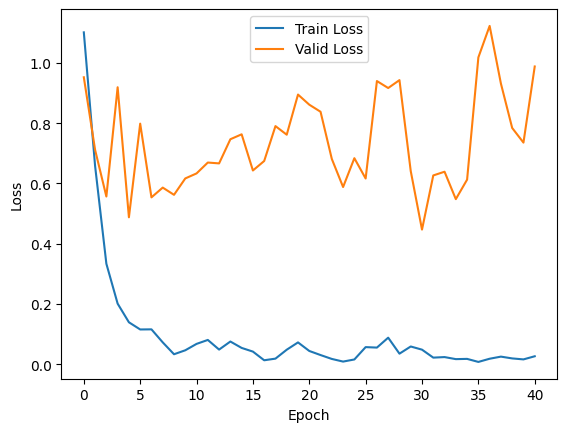

In [10]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv1, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv1, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv1, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.86, Test F1-Score: 0.86, Avg Time: 0.0067 seconds


In [12]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv1, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.86, Test F1-Score: 0.86, Avg Time: 0.0165 seconds


In [13]:
#save model
mobilenetv1.eval()
torch.save(mobilenetv1.state_dict(), 'MRIModels/mobilenetv1.pth')

# MobileNetV2

**MobileNetV2 pretrained from transformers HuggingFace**

In [14]:
from transformers import MobileNetV2ForImageClassification

mobilenetv2 = MobileNetV2ForImageClassification.from_pretrained('google/mobilenet_v2_1.0_224')

mobilenetv2.classifier = nn.Linear(mobilenetv2.classifier.in_features, out_features=num_classes, bias=True)

mobilenetv2.to(device)

print(mobilenetv2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=lr)

MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

Epoch 1/100, Train Loss: 1.0257, Valid Loss: 0.9876
Epoch 2/100, Train Loss: 0.7388, Valid Loss: 0.7049
Epoch 3/100, Train Loss: 0.4568, Valid Loss: 0.7361
Epoch 4/100, Train Loss: 0.3191, Valid Loss: 1.0411
Epoch 5/100, Train Loss: 0.2930, Valid Loss: 0.5797
Epoch 6/100, Train Loss: 0.1525, Valid Loss: 0.6625
Epoch 7/100, Train Loss: 0.1043, Valid Loss: 0.8503
Epoch 8/100, Train Loss: 0.1447, Valid Loss: 0.7803
Epoch 9/100, Train Loss: 0.0987, Valid Loss: 0.6711
Epoch 10/100, Train Loss: 0.0775, Valid Loss: 0.6215
Epoch 11/100, Train Loss: 0.0515, Valid Loss: 0.6828
Epoch 12/100, Train Loss: 0.0531, Valid Loss: 0.7176
Epoch 13/100, Train Loss: 0.0750, Valid Loss: 0.8088
Epoch 14/100, Train Loss: 0.0922, Valid Loss: 0.6134
Epoch 15/100, Train Loss: 0.0630, Valid Loss: 0.6299
Epoch 16/100, Train Loss: 0.0237, Valid Loss: 0.6132
Epoch 17/100, Train Loss: 0.0284, Valid Loss: 0.7365
Epoch 18/100, Train Loss: 0.0527, Valid Loss: 1.5883
Epoch 19/100, Train Loss: 0.1313, Valid Loss: 0.7918
Ep

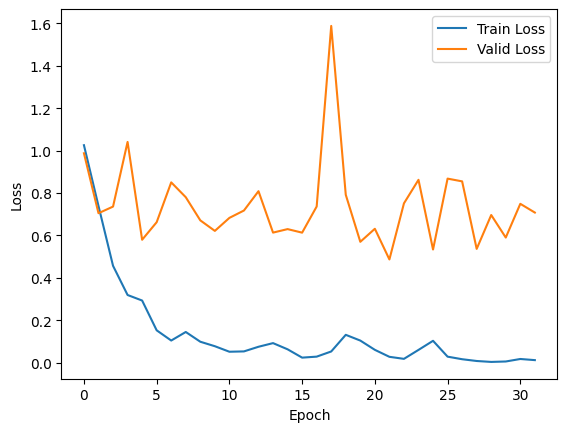

In [15]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv2, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv2, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv2, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.86, Test F1-Score: 0.86, Avg Time: 0.0112 seconds


In [17]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv2, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.87, Test F1-Score: 0.87, Avg Time: 0.0173 seconds


In [18]:
#save model
torch.save(mobilenetv2.state_dict(), 'MRIModels/mobilenetv2.pth')

# MobileNetV3

**MobileNetV3 pretrained from torchvision**

In [19]:
from torchvision.models import mobilenet_v3_small,  MobileNet_V3_Small_Weights

mobilenetv3 = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

mobilenetv3.classifier[3] = nn.Linear(mobilenetv3.classifier[3].in_features, out_features=num_classes, bias=True)

mobilenetv3.to(device)

print(mobilenetv3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3.parameters(), lr=lr)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

Epoch 1/100, Train Loss: 1.0221, Valid Loss: 1.0630
Epoch 2/100, Train Loss: 0.7689, Valid Loss: 2.2827
Epoch 3/100, Train Loss: 0.4891, Valid Loss: 3.0857
Epoch 4/100, Train Loss: 0.2573, Valid Loss: 7.2068
Epoch 5/100, Train Loss: 0.1796, Valid Loss: 2.6207
Epoch 6/100, Train Loss: 0.1358, Valid Loss: 1.7974
Epoch 7/100, Train Loss: 0.1024, Valid Loss: 1.3911
Epoch 8/100, Train Loss: 0.0727, Valid Loss: 2.2771
Epoch 9/100, Train Loss: 0.0665, Valid Loss: 0.8994
Epoch 10/100, Train Loss: 0.0602, Valid Loss: 1.7989
Epoch 11/100, Train Loss: 0.0533, Valid Loss: 2.3998
Epoch 12/100, Train Loss: 0.0630, Valid Loss: 2.1473
Epoch 13/100, Train Loss: 0.0649, Valid Loss: 1.4918
Epoch 14/100, Train Loss: 0.0662, Valid Loss: 2.9887
Epoch 15/100, Train Loss: 0.0235, Valid Loss: 1.8529
Epoch 16/100, Train Loss: 0.0145, Valid Loss: 1.1604
Epoch 17/100, Train Loss: 0.0221, Valid Loss: 1.1899
Epoch 18/100, Train Loss: 0.0948, Valid Loss: 0.8356
Epoch 19/100, Train Loss: 0.0223, Valid Loss: 0.9923
Ep

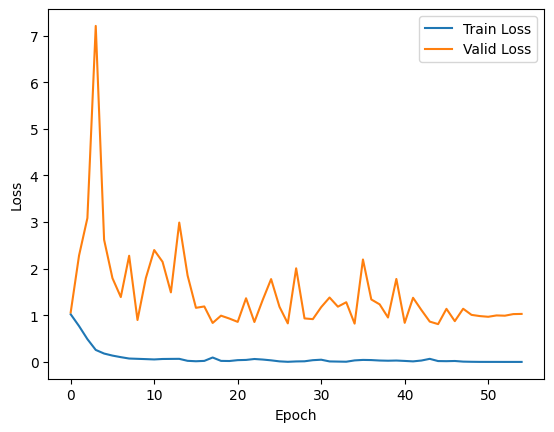

In [20]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv3, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv3, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv3, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.88, Test F1-Score: 0.87, Avg Time: 0.0080 seconds


In [22]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv3, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.88, Test F1-Score: 0.87, Avg Time: 0.0074 seconds


In [23]:
#save model
torch.save(mobilenetv3.state_dict(), 'MRIModels/mobilenetv3.pth')

# MobileNetV4

MobileNetV4 pretrained from timm HuggingFace

In [9]:
import timm

mobilenetv4 = timm.create_model('mobilenetv4_conv_small.e1200_r224_in1k', pretrained=True, num_classes=num_classes)

mobilenetv4.to(device)

print(mobilenetv4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv4.parameters(), lr=lr)

MobileNetV3(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Iden

Epoch 1/100, Train Loss: 2.2067, Valid Loss: 1.2068
Epoch 2/100, Train Loss: 0.9994, Valid Loss: 0.9838
Epoch 3/100, Train Loss: 0.9730, Valid Loss: 0.9898
Epoch 4/100, Train Loss: 0.9371, Valid Loss: 1.0396
Epoch 5/100, Train Loss: 0.8097, Valid Loss: 1.1189
Epoch 6/100, Train Loss: 0.6732, Valid Loss: 1.1004
Epoch 7/100, Train Loss: 0.5923, Valid Loss: 1.0674
Epoch 8/100, Train Loss: 0.5200, Valid Loss: 1.3841
Epoch 9/100, Train Loss: 0.4608, Valid Loss: 0.7586
Epoch 10/100, Train Loss: 0.3642, Valid Loss: 0.8953
Epoch 11/100, Train Loss: 0.4444, Valid Loss: 0.6347
Epoch 12/100, Train Loss: 0.2235, Valid Loss: 0.8581
Epoch 13/100, Train Loss: 0.2594, Valid Loss: 1.1531
Epoch 14/100, Train Loss: 0.2679, Valid Loss: 0.9744
Epoch 15/100, Train Loss: 0.2081, Valid Loss: 0.8353
Epoch 16/100, Train Loss: 0.1895, Valid Loss: 0.7928
Epoch 17/100, Train Loss: 0.2784, Valid Loss: 0.7119
Epoch 18/100, Train Loss: 0.1586, Valid Loss: 0.8159
Epoch 19/100, Train Loss: 0.1830, Valid Loss: 0.7063
Ep

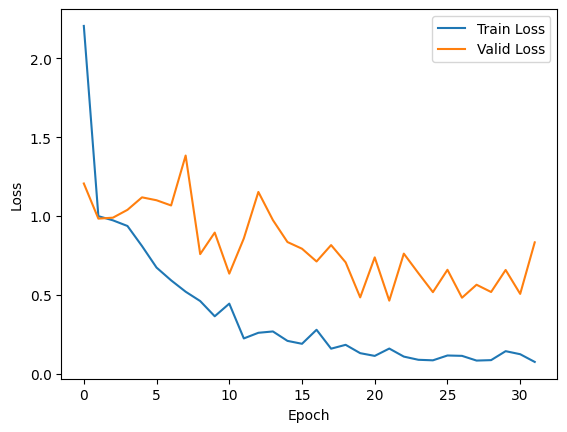

In [10]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(mobilenetv4, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(mobilenetv4, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv4, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.83, Test F1-Score: 0.83, Avg Time: 0.0074 seconds


In [12]:
_, test_accuracy, test_f1, avg_time = test(mobilenetv4, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.83, Test F1-Score: 0.83, Avg Time: 0.0108 seconds


In [13]:
#save model
torch.save(mobilenetv4.state_dict(), 'MRIModels/mobilenetv4.pth')

# EfficientFormer

In [29]:
import timm

efficientformer = timm.create_model('efficientformerv2_s2.snap_dist_in1k', pretrained=True, num_classes=num_classes)

efficientformer.to(device)

print(efficientformer)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientformer.parameters(), lr=lr)

EfficientFormerV2(
  (stem): Stem4(
    (conv1): ConvNormAct(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): GELU()
      )
    )
  )
  (stages): Sequential(
    (0): EfficientFormerV2Stage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): EfficientFormerV2Block(
          (mlp): ConvMlpWithNorm(
            (fc1): ConvNormAct(
              (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
              (bn): BatchNormAct2d(
                128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
     

Epoch 1/100, Train Loss: 1.0364, Valid Loss: 1.1371
Epoch 2/100, Train Loss: 0.8033, Valid Loss: 0.8639
Epoch 3/100, Train Loss: 0.4781, Valid Loss: 0.7022
Epoch 4/100, Train Loss: 0.3323, Valid Loss: 0.5571
Epoch 5/100, Train Loss: 0.1617, Valid Loss: 0.7593
Epoch 6/100, Train Loss: 0.1088, Valid Loss: 0.7885
Epoch 7/100, Train Loss: 0.0499, Valid Loss: 0.5126
Epoch 8/100, Train Loss: 0.0659, Valid Loss: 0.5725
Epoch 9/100, Train Loss: 0.1207, Valid Loss: 0.6547
Epoch 10/100, Train Loss: 0.0891, Valid Loss: 1.4132
Epoch 11/100, Train Loss: 0.0653, Valid Loss: 1.3240
Epoch 12/100, Train Loss: 0.0696, Valid Loss: 0.7287
Epoch 13/100, Train Loss: 0.0361, Valid Loss: 0.5192
Epoch 14/100, Train Loss: 0.0271, Valid Loss: 0.5699
Epoch 15/100, Train Loss: 0.0392, Valid Loss: 0.5994
Epoch 16/100, Train Loss: 0.0287, Valid Loss: 0.5278
Epoch 17/100, Train Loss: 0.0175, Valid Loss: 0.5472
Epoch 18/100, Train Loss: 0.0592, Valid Loss: 0.5616
Epoch 19/100, Train Loss: 0.0411, Valid Loss: 0.5176
Ep

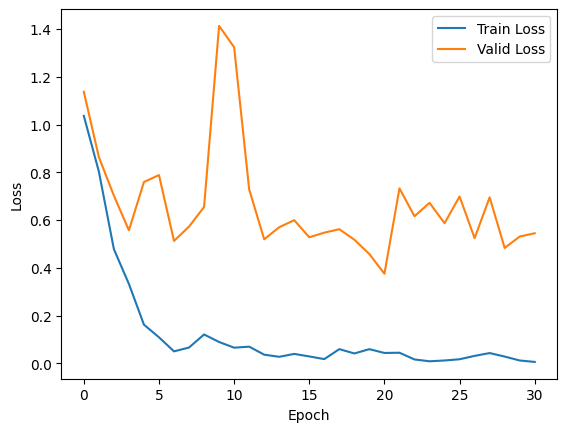

In [30]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(efficientformer, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(efficientformer, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
_, test_accuracy, test_f1, avg_time = test(efficientformer, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.94, Test F1-Score: 0.94, Avg Time: 0.0268 seconds


In [32]:
_, test_accuracy, test_f1, avg_time = test(efficientformer, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.94, Test F1-Score: 0.94, Avg Time: 0.0451 seconds


In [33]:
#save model
torch.save(efficientformer.state_dict(), 'MRIModels/efficientformer.pth')

# LiteFBCN

In [34]:
from torchvision.models import mobilenet_v2
from torch.nn import functional as F

class LiteFBCN(nn.Module):
    def __init__(self, num_classes=5,
                 img_shape=(3, 224, 224),
                 channel_reducer=640):

        super(LiteFBCN, self).__init__()
        self.num_classes = num_classes
        self.img_shape = img_shape
        self.channel_reducer = channel_reducer

        # Backbone
        self.backbone_model = mobilenet_v2(pretrained=True)

        # Channel reducer
        self.conv_reduce = nn.Conv2d(1280, channel_reducer, kernel_size=1)

        # Final layer
        self.final_layers = nn.Sequential(
            nn.Linear(channel_reducer * channel_reducer, num_classes)
        )

    def outer_product(self, x1, x2):
        batch_size, channels, height, width = x1.size()

        # Einstein summation
        phi_I = torch.einsum('bchw,bdhw->bcd', x1, x2)

        # Reshape
        phi_I = phi_I.view(batch_size, -1)

        # Divide by feature map size
        size = height * width
        phi_I = phi_I / size

        # Signed square root
        y_ssqrt = torch.sign(phi_I) * torch.sqrt(torch.abs(phi_I) + 1e-12)

        # L2 normalization
        z_l2 = F.normalize(y_ssqrt, p=2, dim=1)
        return z_l2

    def forward(self, x):
        x = self.backbone_model.features(x)

        x = F.relu(self.conv_reduce(x))

        d1 = F.dropout(x, p=0.5, training=self.training)
        d2 = F.dropout(x, p=0.5, training=self.training)

        x = self.outer_product(d1, d2)
        x = self.final_layers(x)

        return x

    def build_model(self):
        return self

In [35]:
litefbcn = LiteFBCN(num_classes=3, img_shape=(3, 224, 224), channel_reducer=640)

litefbcn.to(device)

print(litefbcn)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(litefbcn.parameters(), lr=lr)

LiteFBCN(
  (backbone_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_siz

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(litefbcn, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('MMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")

LiteFBCN(
  5.55 M, 100.000% Params, 360.36 MMac, 99.991% MACs, 
  (backbone_model): MobileNetV2(
    3.5 M, 63.111% Params, 318.96 MMac, 88.503% MACs, 
    (features): Sequential(
      2.22 M, 40.044% Params, 318.96 MMac, 88.503% MACs, 
      (0): Conv2dNormActivation(
        928, 0.017% Params, 12.04 MMac, 3.341% MACs, 
        (0): Conv2d(864, 0.016% Params, 10.84 MMac, 3.007% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, 0.001% Params, 802.82 KMac, 0.223% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(0, 0.000% Params, 401.41 KMac, 0.111% MACs, inplace=True)
      )
      (1): InvertedResidual(
        896, 0.016% Params, 11.64 MMac, 3.230% MACs, 
        (conv): Sequential(
          896, 0.016% Params, 11.64 MMac, 3.230% MACs, 
          (0): Conv2dNormActivation(
            352, 0.006% Params, 4.82 MMac, 1.337% MACs, 
            (0): Conv2d(288, 0.005% Params, 3.61 MMac, 

Epoch 1/100, Train Loss: 1.0115, Valid Loss: 1.0272
Epoch 2/100, Train Loss: 0.9431, Valid Loss: 0.9850
Epoch 3/100, Train Loss: 0.8462, Valid Loss: 0.9503
Epoch 4/100, Train Loss: 0.7578, Valid Loss: 1.1815
Epoch 5/100, Train Loss: 0.6190, Valid Loss: 0.7782
Epoch 6/100, Train Loss: 0.5593, Valid Loss: 0.8080
Epoch 7/100, Train Loss: 0.4775, Valid Loss: 1.1447
Epoch 8/100, Train Loss: 0.4308, Valid Loss: 0.9834
Epoch 9/100, Train Loss: 0.4068, Valid Loss: 0.8600
Epoch 10/100, Train Loss: 0.2668, Valid Loss: 0.7371
Epoch 11/100, Train Loss: 0.1644, Valid Loss: 0.7662
Epoch 12/100, Train Loss: 0.1544, Valid Loss: 0.8232
Epoch 13/100, Train Loss: 0.1770, Valid Loss: 1.8495
Epoch 14/100, Train Loss: 0.1826, Valid Loss: 3.6448
Epoch 15/100, Train Loss: 0.1641, Valid Loss: 1.0245
Epoch 16/100, Train Loss: 0.1441, Valid Loss: 2.4540
Epoch 17/100, Train Loss: 0.1201, Valid Loss: 1.8626
Epoch 18/100, Train Loss: 0.0863, Valid Loss: 1.2181
Epoch 19/100, Train Loss: 0.1102, Valid Loss: 1.0949
Ep

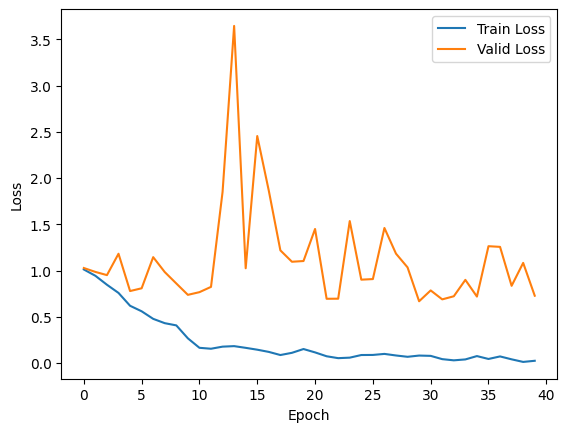

In [37]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(litefbcn, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _= test(litefbcn, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
_, test_accuracy, test_f1, avg_time = test(litefbcn, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.87, Test F1-Score: 0.87, Avg Time: 0.0080 seconds


In [39]:
_, test_accuracy, test_f1, avg_time = test(litefbcn, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.87, Test F1-Score: 0.87, Avg Time: 0.0151 seconds


In [40]:
#save model
torch.save(litefbcn.state_dict(), 'MRIModels/litefbcn.pth')

# AD-Lite Net

In [41]:
import torch
import torch.nn as nn

class AdLiteNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AdLiteNet, self).__init__()

        # Initial Conv Block: 224x224x3 -> 112x112x32
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 224x224x3 -> 112x112x32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Conv Block 2: 112x112x32 -> 56x56x64
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 112x112x32 -> 112x112x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112x112x64 -> 56x56x64
        )

        # Parallel Concatenation Block
        # Branch 1: 56x56x64 -> 28x28x96
        self.branch1 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  # 56x56x64 -> 56x56x96
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 56x56x96 -> 28x28x96
        )

        # Branch 2: 56x56x64 -> 14x14x96
        self.branch2 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  # 56x56x64 -> 56x56x96
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=4)  # 56x56x96 -> 14x14x96
        )

        # Branch 3: 56x56x64 -> 14x14x64 (Depthwise Separable Conv)
        self.branch3 = nn.Sequential(
            # Depthwise
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64),
            # Pointwise
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=4)  # 56x56x64 -> 14x14x64
        )

        # Branch 4: 56x56x64 -> 7x7x64
        self.branch4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 56x56x64 -> 56x56x64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=8, stride=8)  # 56x56x64 -> 7x7x64
        )

        # After concatenation: 7x7x224 (96 + 96 + 64 = 256, but diagram shows 192, so adjust)
        # Adjusting the branches to match 192 channels for global average pooling
        self.adjust_branch2 = nn.Conv2d(96, 32, kernel_size=1)  # Reduce branch2 from 96 to 32 to match 192 total

        # Global Average Pooling: 7x7x192 -> 1x1x192
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer: 192 -> 3 (output classes)
        self.drop_fc = nn.Dropout(0.5)
        self.fc = nn.Linear(192, num_classes)

    def forward(self, x):
        # Initial conv blocks
        x = self.conv1(x)  # 224x224x3 -> 112x112x32
        x = self.conv2(x)  # 112x112x32 -> 56x56x64

        # Parallel branches
        b1 = self.branch1(x)  # 56x56x64 -> 28x28x96
        b2 = self.branch2(x)  # 56x56x64 -> 14x14x96
        b3 = self.branch3(x)  # 56x56x64 -> 14x14x64
        b4 = self.branch4(x)  # 56x56x64 -> 7x7x64

        # Adjust branch2 to reduce channels to match 192 total (96 + 32 + 64 = 192)
        b2 = self.adjust_branch2(b2)  # 14x14x96 -> 14x14x32

        # Upsample/downsample to match 7x7 resolution for concatenation
        b1 = nn.functional.interpolate(b1, size=(7, 7), mode='bilinear', align_corners=False)  # 28x28x96 -> 7x7x96
        b2 = nn.functional.interpolate(b2, size=(7, 7), mode='bilinear', align_corners=False)  # 14x14x32 -> 7x7x32
        b3 = nn.functional.interpolate(b3, size=(7, 7), mode='bilinear', align_corners=False)  # 14x14x64 -> 7x7x64

        # Concatenate along channel dimension (96 + 32 + 64 = 192 channels)
        x = torch.cat((b1, b2, b3), dim=1)  # 7x7x192

        # Global Average Pooling
        x = self.global_avg_pool(x)  # 7x7x192 -> 1x1x192
        x = x.view(x.size(0), -1)  # Flatten: 1x1x192 -> 192

        x = self.drop_fc(x)

        # Final FC layer
        x = self.fc(x)  # 192 -> 3 (num_classes)

        return x

In [42]:
adlitenet = AdLiteNet(num_classes=3)
adlitenet.to(device)

print(adlitenet)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(adlitenet.parameters(), lr=lr)

AdLiteNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch1): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch2): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, 

In [43]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(adlitenet, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('MMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")

AdLiteNet(
  176.42 k, 100.000% Params, 730.58 MMac, 99.451% MACs, 
  (conv1): Sequential(
    960, 0.544% Params, 12.44 MMac, 1.694% MACs, 
    (0): Conv2d(896, 0.508% Params, 11.24 MMac, 1.530% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, 0.036% Params, 802.82 KMac, 0.109% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 401.41 KMac, 0.055% MACs, inplace=True)
  )
  (conv2): Sequential(
    18.62 k, 10.557% Params, 235.23 MMac, 32.020% MACs, 
    (0): Conv2d(18.5 k, 10.484% Params, 232.01 MMac, 31.583% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, 0.073% Params, 1.61 MMac, 0.219% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 802.82 KMac, 0.109% MACs, inplace=True)
    (3): MaxPool2d(0, 0.000% Params, 802.82 KMac, 0.109% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

Epoch 1/300, Train Loss: 1.0810, Valid Loss: 1.0380, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 2/300, Train Loss: 1.0546, Valid Loss: 1.0406, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 3/300, Train Loss: 1.0520, Valid Loss: 1.0340, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 4/300, Train Loss: 1.0421, Valid Loss: 1.0501, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 5/300, Train Loss: 1.0385, Valid Loss: 1.0370, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 6/300, Train Loss: 1.0364, Valid Loss: 1.0333, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 7/300, Train Loss: 1.0369, Valid Loss: 1.0505, Valid Accuracy: 0.4749, Valid F1-Score: 0.3785
Epoch 8/300, Train Loss: 1.0326, Valid Loss: 1.0373, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 9/300, Train Loss: 1.0413, Valid Loss: 1.0324, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872
Epoch 10/300, Train Loss: 1.0397, Valid Loss: 1.0359, Valid Accuracy: 0.4575, Valid F1-Score: 0.2872

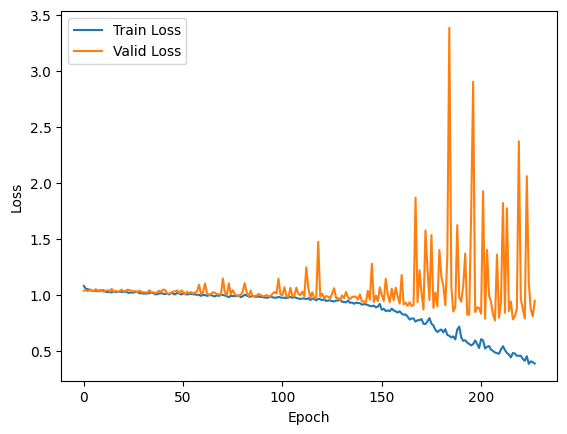

In [44]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

epochs = 300

for epoch in range(epochs):
    train_loss = train(adlitenet, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(adlitenet, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}, Valid F1-Score: {val_f1:.4f}')

    # early stoping with patience = 5
    if epoch > 200:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= 20:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
_, test_accuracy, test_f1, avg_time = test(adlitenet, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.61, Test F1-Score: 0.57, Avg Time: 0.0017 seconds


In [46]:
_, test_accuracy, test_f1, avg_time = test(adlitenet, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.61, Test F1-Score: 0.57, Avg Time: 0.0103 seconds


In [47]:
adlitenet.eval()
torch.save(adlitenet.state_dict(), 'MRIModels/adlitenet.pth')

# SBCFormer

In [20]:
from SBCFormer.models.sbcformer import SBCFormer_B
import torch
import torch.nn as nn

sbcformer = SBCFormer_B()

# load checkpoint
checkpoint = torch.load('D:/HocTap/NCKH/LightweightModels/SBCFormer_B_IMNET_checkpoint.pth')

sbcformer.load_state_dict(checkpoint['model'], strict=False)

sbcformer.head = nn.Linear(sbcformer.head.in_features, out_features=3, bias=True)

print(sbcformer)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sbcformer.parameters(), lr=lr)

sbcformer.to(device)

C:\Users\NCQH\AppData\Local\Temp\ipykernel_9368\4019916918.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('D:/HocTap/NCKH/LightweightModels/SBCF

SBCFormer(
  (merging_blocks): ModuleList(
    (0): PatchEmbed(
      (stem): Sequential(
        (0): Conv2d_BN(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU(inplace=True)
        (2): Conv2d_BN(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (3): ReLU(inplace=True)
        (4): Conv2d_BN(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (5): ReLU(inplace=True)
      )
    )
    (1): PatchMerging(
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

SBCFormer(
  (merging_blocks): ModuleList(
    (0): PatchEmbed(
      (stem): Sequential(
        (0): Conv2d_BN(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU(inplace=True)
        (2): Conv2d_BN(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (3): ReLU(inplace=True)
        (4): Conv2d_BN(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (5): ReLU(inplace=True)
      )
    )
    (1): PatchMerging(
      (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Epoch 1/300, Train Loss: 1.0668, Valid Loss: 1.0563, Valid Accuracy: 0.5098, Valid F1-Score: 0.4420
Epoch 2/300, Train Loss: 0.8875, Valid Loss: 0.9565, Valid Accuracy: 0.5643, Valid F1-Score: 0.5153
Epoch 3/300, Train Loss: 0.8025, Valid Loss: 0.9850, Valid Accuracy: 0.5207, Valid F1-Score: 0.4254
Epoch 4/300, Train Loss: 0.4913, Valid Loss: 1.4174, Valid Accuracy: 0.4619, Valid F1-Score: 0.3962
Epoch 5/300, Train Loss: 0.3326, Valid Loss: 1.0782, Valid Accuracy: 0.6187, Valid F1-Score: 0.5608
Epoch 6/300, Train Loss: 0.2179, Valid Loss: 0.5979, Valid Accuracy: 0.7821, Valid F1-Score: 0.7778
Epoch 7/300, Train Loss: 0.1618, Valid Loss: 0.6033, Valid Accuracy: 0.8431, Valid F1-Score: 0.8405
Epoch 8/300, Train Loss: 0.1270, Valid Loss: 0.6001, Valid Accuracy: 0.7756, Valid F1-Score: 0.7769
Epoch 9/300, Train Loss: 0.1489, Valid Loss: 2.0360, Valid Accuracy: 0.4488, Valid F1-Score: 0.3870
Epoch 10/300, Train Loss: 0.0988, Valid Loss: 0.7181, Valid Accuracy: 0.7669, Valid F1-Score: 0.7681

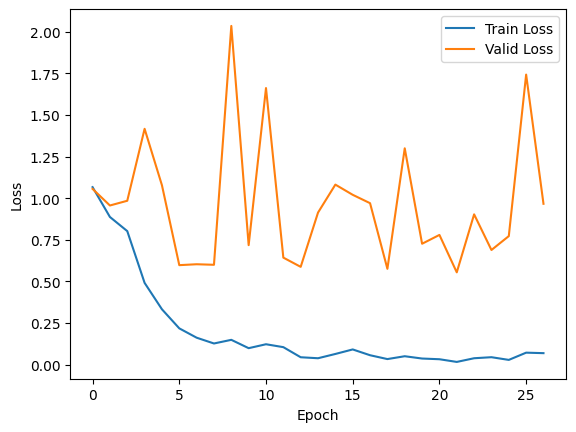

In [21]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

epochs = 300

for epoch in range(epochs):
    train_loss = train(sbcformer, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(sbcformer, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}, Valid F1-Score: {val_f1:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= 5:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
_, test_accuracy, test_f1, avg_time = test(sbcformer, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.84, Test F1-Score: 0.83, Avg Time: 0.0184 seconds


In [24]:
_, test_accuracy, test_f1, avg_time = test(sbcformer, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.84, Test F1-Score: 0.83, Avg Time: 0.0316 seconds


In [ ]:
#save model
torch.save(sbcformer.state_dict(), 'MRIModels/sbcformer.pth')

In [8]:
import timm

resnet50 = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=num_classes)

resnet50.to(device)

print(resnet50)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=lr)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [9]:
from ptflops import get_model_complexity_info

#model = MyModel()

macs, params = get_model_complexity_info(resnet50, (3, 224, 224), as_strings=True, print_per_layer_stat=True)
flops = 2 * float(macs.replace('GMac', '')) * 1e6
print(f"FLOPs: {flops}")
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")

ResNet(
  23.51 M, 100.000% Params, 4.12 GMac, 99.745% MACs, 
  (conv1): Conv2d(9.41 k, 0.040% Params, 118.01 MMac, 2.857% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(128, 0.001% Params, 1.61 MMac, 0.039% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(0, 0.000% Params, 802.82 KMac, 0.019% MACs, inplace=True)
  (maxpool): MaxPool2d(0, 0.000% Params, 802.82 KMac, 0.019% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    215.81 k, 0.918% Params, 680.39 MMac, 16.473% MACs, 
    (0): Bottleneck(
      75.01 k, 0.319% Params, 236.43 MMac, 5.724% MACs, 
      (conv1): Conv2d(4.1 k, 0.017% Params, 12.85 MMac, 0.311% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, 0.001% Params, 401.41 KMac, 0.010% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(0, 0.000% Params, 200.

Epoch 1/100, Train Loss: 1.0318, Valid Loss: 1.0288
Epoch 2/100, Train Loss: 0.9394, Valid Loss: 1.0842
Epoch 3/100, Train Loss: 0.7317, Valid Loss: 1.1697
Epoch 4/100, Train Loss: 0.4166, Valid Loss: 1.0290
Epoch 5/100, Train Loss: 0.3284, Valid Loss: 1.6513
Epoch 6/100, Train Loss: 0.2034, Valid Loss: 0.6693
Epoch 7/100, Train Loss: 0.0916, Valid Loss: 0.8466
Epoch 8/100, Train Loss: 0.0800, Valid Loss: 0.8810
Epoch 9/100, Train Loss: 0.0666, Valid Loss: 1.8935
Epoch 10/100, Train Loss: 0.0640, Valid Loss: 1.2325
Epoch 11/100, Train Loss: 0.0466, Valid Loss: 0.9770
Epoch 12/100, Train Loss: 0.0694, Valid Loss: 1.2153
Epoch 13/100, Train Loss: 0.0256, Valid Loss: 0.9807
Epoch 14/100, Train Loss: 0.0448, Valid Loss: 1.1539
Epoch 15/100, Train Loss: 0.0644, Valid Loss: 4.7503
Epoch 16/100, Train Loss: 0.0590, Valid Loss: 0.4077
Epoch 17/100, Train Loss: 0.0185, Valid Loss: 2.3854
Epoch 18/100, Train Loss: 0.0400, Valid Loss: 0.6722
Epoch 19/100, Train Loss: 0.0281, Valid Loss: 0.8705
Ep

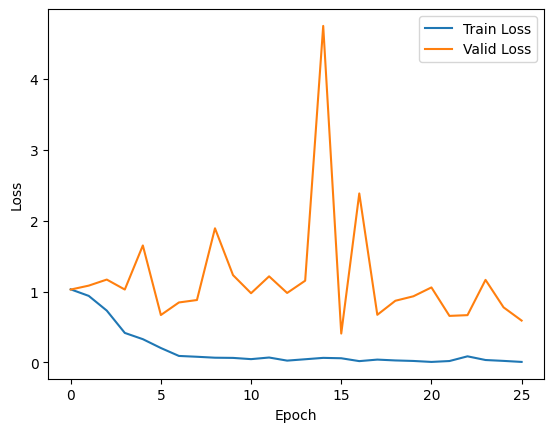

In [14]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss = train(resnet50, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, val_f1, _ = test(resnet50, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')

    # early stoping with patience = 5
    if epoch > 10:
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print("Early stopping")
              break

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
_, test_accuracy, test_f1, avg_time = test(resnet50, test_loader, criterion, 'cuda')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.89, Test F1-Score: 0.89, Avg Time: 0.0078 seconds


In [16]:
_, test_accuracy, test_f1, avg_time = test(resnet50, test_loader, criterion, 'cpu')
print(f'Test Accuracy: {test_accuracy:.2f}, Test F1-Score: {test_f1:.2f}, Avg Time: {avg_time:.4f} seconds')

Test Accuracy: 0.89, Test F1-Score: 0.89, Avg Time: 0.0493 seconds


In [17]:
#save model
torch.save(resnet50.state_dict(), 'MRIModels/resnet50.pth')